# LSTM with attention architecture

## NN for language translation (Portugese to English)

Will extract weights from the training.

In [ ]:
pip install -q tensorflow_datasets

In [ ]:
pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 12.4MB/s 


In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set(font_scale=1.5)

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteO3YCXC/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteO3YCXC/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteO3YCXC/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [ ]:
examples

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'validation': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>}

In [ ]:
train_examples, val_examples = examples['train'], examples['validation']

In [ ]:
train_examples

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [ ]:
# no of examples: 51785
for pt_examples, en_examples in train_examples.batch(1).take(20):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  for en in en_examples.numpy():
    print(en.decode('utf-8'))
  
  print()

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .

mas e se estes fatores fossem ativos ?
but what if it were active ?

mas eles não tinham a curiosidade de me testar .
but they did n't test for curiosity .

e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .
and this conscious defiance is why i , as an agnostic , can still have faith .

`` `` '' podem usar tudo sobre a mesa no meu corpo . ''
you can use everything on the table on me .

`` eu escrevo muito acerca do `` '' teatro de segurança '' '' , que são produtos que fazem as pessoas sentirem-se seguras mas que , na realidade , não fazem nada . ''
`` i write a lot about `` '' security theater , '' '' which are products that make people feel secure , but do n't actually do anything . ''

colocaram-no bem no fundo duma mina de ferro no minnes

In [ ]:
# Only work with smaller data set as number of nodes in final layer of 
# LSTM with attention is equal to vocab size (number of unique words) in 
# training set. Using the full dataset of 51785 examples will generate a 
# vocab size of 17000+ words, where we have insufficient RAM. The original
# nn architecture was only meant to train small datasets. LSTM seems to take 
# more memory, else we might get [_derived_]recvasync is cancelled error

def create_dataset(training_data):
    the_data = []
    for pt_examples, en_examples in training_data.batch(1).take(1500):
        curr_example = []
        for en in en_examples.numpy():
            contents_en = '<start> ' + en.decode('utf-8') + ' <end>'
            curr_example.append(contents_en)
        for pt in pt_examples.numpy():
            contents_pt = '<start> ' + pt.decode('utf-8') + ' <end>'
            curr_example.append(contents_pt)
        the_data.append(curr_example)
    return zip(*the_data)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(data):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(data)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
input_tensor_train, target_tensor_train, inp_lang, targ_lang = load_dataset(train_examples)

In [ ]:
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]

In [ ]:
input_tensor_val, target_tensor_val, _, _ = load_dataset(val_examples)

In [ ]:
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

1500 1500 1193 1193


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f'{t} ----> {lang.index_word[t]}')

In [ ]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
8 ----> e
41 ----> quando
1833 ----> melhoramos
5 ----> a
759 ----> procura
1 ----> ,
1834 ----> tiramos
5 ----> a
351 ----> única
1835 ----> vantagem
22 ----> da
760 ----> impressão
1 ----> ,
7 ----> que
10 ----> é
5 ----> a
1836 ----> serendipidade
4 ----> .
3 ----> <end>

Target Language; index to word mapping
1 ----> <start>
6 ----> and
48 ----> when
16 ----> you
739 ----> improve
1678 ----> searchability
4 ----> ,
16 ----> you
90 ----> actually
131 ----> take
308 ----> away
5 ----> the
40 ----> one
1679 ----> advantage
8 ----> of
1680 ----> print
4 ----> ,
107 ----> which
14 ----> is
1681 ----> serendipity
3 ----> .
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 2
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
#vocab_inp_size = 8500
#vocab_tar_size = 8000

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
vocab_inp_size

5290

In [ ]:
vocab_tar_size

4385

In [ ]:
dataset

<BatchDataset shapes: ((2, 119), (2, 144)), types: (tf.int32, tf.int32)>

In [ ]:
len(input_tensor_train)

1500

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([2, 119]), TensorShape([2, 144]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state, state_c = self.lstm(x, initial_state=hidden)
    return output, state, state_c

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden, sample_hidden_c = encoder(example_input_batch, [sample_hidden, sample_hidden])
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (2, 119, 1024)
Encoder Hidden state shape: (batch size, units) (2, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (2, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (2, 119, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    output, state, state_c = self.lstm(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (2, 4385)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
DICT_WEIGHTS = {}
# DICT_TV = {}

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden, enc_hidden_c = encoder(inp, [enc_hidden, enc_hidden])

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
  
  DICT_WEIGHTS[epoch] = decoder.fc.get_weights()
  # DICT_TV[epoch] = decoder.fc.trainable_variables

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.3686
Epoch 1 Batch 100 Loss 0.3307
Epoch 1 Batch 200 Loss 0.8101
Epoch 1 Batch 300 Loss 0.5419
Epoch 1 Batch 400 Loss 0.2793
Epoch 1 Batch 500 Loss 0.5893
Epoch 1 Batch 600 Loss 0.6053
Epoch 1 Batch 700 Loss 1.0877
Epoch 1 Loss 0.7670
Time taken for 1 epoch 443.06 sec

Epoch 2 Batch 0 Loss 0.4763
Epoch 2 Batch 100 Loss 0.3133
Epoch 2 Batch 200 Loss 0.8753
Epoch 2 Batch 300 Loss 0.9109
Epoch 2 Batch 400 Loss 0.7705
Epoch 2 Batch 500 Loss 0.3098
Epoch 2 Batch 600 Loss 0.9266
Epoch 2 Batch 700 Loss 0.6477
Epoch 2 Loss 0.6700
Time taken for 1 epoch 275.45 sec

Epoch 3 Batch 0 Loss 0.3743
Epoch 3 Batch 100 Loss 0.2460
Epoch 3 Batch 200 Loss 0.1693
Epoch 3 Batch 300 Loss 1.1268
Epoch 3 Batch 400 Loss 1.5670
Epoch 3 Batch 500 Loss 0.4868
Epoch 3 Batch 600 Loss 0.4895
Epoch 3 Batch 700 Loss 0.5547
Epoch 3 Loss 0.6092
Time taken for 1 epoch 274.47 sec

Epoch 4 Batch 0 Loss 0.3410
Epoch 4 Batch 100 Loss 0.2925
Epoch 4 Batch 200 Loss 0.7255
Epoch 4 Batch 300 Loss 0.4697
Epo

In [ ]:
'''
@tf.function
def example():

  with tf.GradientTape() as tape:
    tensor_var = DICT_TV[0]
    tape.watch(tensor_var)
    tensor_weights = list(map(lambda x: tf.convert_to_tensor(x), DICT_WEIGHTS[0]))
    temp = tape.gradient(tensor_weights, DICT_TV[0])

  return temp
'''

'\n@tf.function\ndef example():\n\n  with tf.GradientTape() as tape:\n    tensor_var = DICT_TV[0]\n    tape.watch(tensor_var)\n    tensor_weights = list(map(lambda x: tf.convert_to_tensor(x), DICT_WEIGHTS[0]))\n    temp = tape.gradient(tensor_weights, DICT_TV[0])\n\n  return temp\n'

In [ ]:
# example()

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden, enc_hidden_c = encoder(inputs, [tf.zeros((1, units)), tf.zeros((1, units))])

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> a cirurgia foi um sucesso . <end>
Predicted translation: the surgery was successful . <end> 


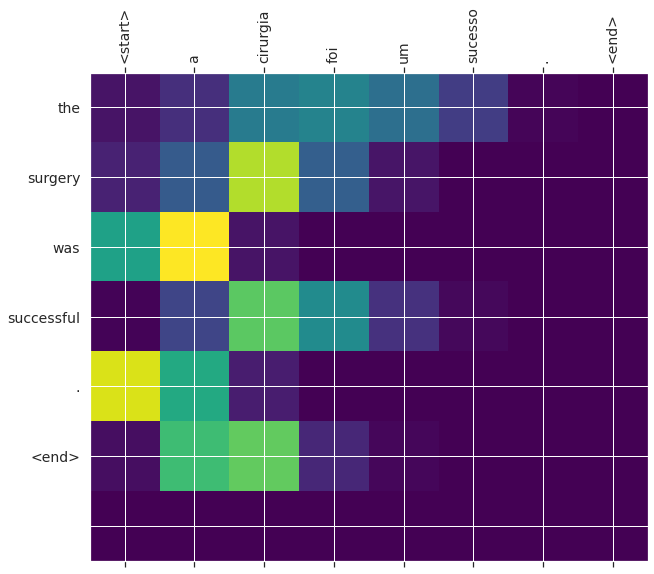

In [ ]:
test_sentence = 'a cirurgia foi um sucesso .'
translate(test_sentence)

In [ ]:
np.save("lstm_attention_100epoch_1500data_weights.npy", DICT_WEIGHTS)

In [ ]:
!cp lstm_attention_100epoch_1500data_weights.npy "drive/My Drive/DSA5204_mine/LSTM_attention"

In [ ]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
encoder.save_weights('encoder_LSTMattention_100epoch_1500dataset.h5')
!cp encoder_LSTMattention_100epoch_1500dataset.h5 "drive/My Drive/DSA5204_mine/LSTM_attention"

In [ ]:
decoder.save_weights('decoder_LSTMattention_100epoch_1500dataset.h5')
!cp decoder_LSTMattention_100epoch_1500dataset.h5 "drive/My Drive/DSA5204_mine/LSTM_attention"

To recall the weights, next time call `encoder.load_weights(path_to_load_weights)` or `decoder.load_weights(path_to_load_weights)`